## 29 Keras Street Signs

In [1]:
import matplotlib.pylab as plt
import numpy as np

%matplotlib inline

In [2]:
colors = 'bwr'#['b','y','r']
CMAP = colors#plt.cm.rainbow

In [3]:
import keras
print(keras.__version__)

Using TensorFlow backend.
/Users/tir/.pyenv/versions/3.6.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


2.2.2


In [4]:
import pandas as pd
print(pd.__version__)

0.23.4


## Load and prepare images

* https://www.dropbox.com/s/g1y0s2cjnple4ak/speed-limit-signs.zip?dl=0 or https://bit.ly/2Nf19V4

In [5]:
!ls -l data/speed-limit-signs

total 4
drwxr-xr-x 81 tir staff 2754 Sep  7 22:20 0
drwxr-xr-x 83 tir staff 2822 Sep  7 22:20 1
drwxr-xr-x 70 tir staff 2380 Sep  7 22:20 2
drwxr-xr-x 55 tir staff 1870 Sep  7 22:20 3
drwxr-xr-x 43 tir staff 1462 Sep  7 22:20 4
drwxr-xr-x 59 tir staff 2006 Sep  7 22:20 5
-rw-r--r--  1 tir staff  380 Sep  7 22:20 README.md


In [6]:
!cat data/speed-limit-signs/README.md

Data extracted from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

From http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip just the samples for the speed limit signs 

## Format

https://en.wikipedia.org/wiki/Netpbm_format

Can be previewed on a Mac and be processed by http://scikit-image.org/

## Labels
- 0: 30
- 1: 50
- 2: 70
- 3: 80
- 4: 100
- 5: 120

> Thanks to [Waleed Abdulla](https://medium.com/@waleedka) for providing the initial idea and many of the functions used to prepare and display the images: https://medium.com/@waleedka/traffic-sign-recognition-with-tensorflow-629dffc391a6#.i728o84ib  

In [7]:
import os
import skimage.data
import skimage.transform
from keras.utils.np_utils import to_categorical
import numpy as np

def load_data(data_dir, type=".ppm"):
    num_categories = 6

    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels, images = [], []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(type)]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    images64 = [skimage.transform.resize(image, (64, 64)) for image in images]
    return images64, labels

In [8]:
# Load datasets.
ROOT_PATH = "data"
original_dir = os.path.join(ROOT_PATH, "speed-limit-signs")
images, labels = load_data(original_dir, type=".ppm")

/Users/tir/.virtualenvs/mlpy/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/tir/.virtualenvs/mlpy/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [9]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)

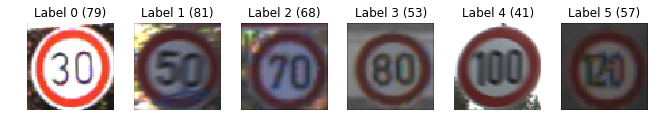

In [10]:
display_images_and_labels(images, labels)

## Architecture

In [11]:
y = np.array(labels)
X = np.array(images)
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [12]:
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

Conv and Maxpool (cat example): 

* > https://imgur.com/a/cFiwKAd

In [13]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       147584    
__________

/Users/tir/.virtualenvs/mlpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

> A first test run.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42, stratify=y)

In [16]:
X_train.shape, y_train.shape

((37, 64, 64, 3), (37, 6))

In [17]:
%time model.fit(X_train, y_train, epochs=10, validation_split=0.3)

Train on 25 samples, validate on 12 samples
Epoch 1/10
25/25 [==============================] - 4s 144ms/step - loss: 1.7931 - acc: 0.0800 - val_loss: 1.8100 - val_acc: 0.0000e+00
Epoch 2/10
25/25 [==============================] - 3s 101ms/step - loss: 1.7171 - acc: 0.2800 - val_loss: 1.6120 - val_acc: 0.3333
Epoch 3/10
25/25 [==============================] - 3s 106ms/step - loss: 1.8330 - acc: 0.1600 - val_loss: 1.8266 - val_acc: 0.0000e+00
Epoch 4/10
25/25 [==============================] - 3s 105ms/step - loss: 1.7127 - acc: 0.3200 - val_loss: 1.8650 - val_acc: 0.0000e+00
Epoch 5/10
25/25 [==============================] - 3s 101ms/step - loss: 1.7473 - acc: 0.2800 - val_loss: 1.8727 - val_acc: 0.0000e+00
Epoch 6/10
25/25 [==============================] - 3s 110ms/step - loss: 1.7301 - acc: 0.2800 - val_loss: 1.9042 - val_acc: 0.0000e+00
Epoch 7/10
25/25 [==============================] - 3s 102ms/step - loss: 1.6868 - acc: 0.2800 - val_loss: 1.8811 - val_acc: 0.0000e+00
Epoch 8/

## Dropout

> Dropout temporarily disables nodes and acts as a regularizer.

In [18]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D

drop_out = 0.6

# input tensor for a 3-channel 64x64 image
inputs = Input(shape=(64, 64, 3))

# one block of convolutional layers
x = Convolution2D(64, 3, activation='relu', padding='same')(inputs)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = Convolution2D(64, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = Convolution2D(128, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

# one more block
x = Convolution2D(256, 3, activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop_out)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(drop_out)(x)

# softmax activation, 6 categories
predictions = Dense(6, activation='softmax')(x)

In [19]:
model = Model(input=inputs, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 128)       73856     
__________

/Users/tir/.virtualenvs/mlpy/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=1)

> Following fit can take a long time on CPU.

In [23]:
BATCH_SIZE = 32
%time model.fit(X_train, y_train, epochs=3, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stopping_callback])

Train on 242 samples, validate on 61 samples
Epoch 1/3
242/242 [==============================] - 24s 101ms/step - loss: 1.9825 - acc: 0.2314 - val_loss: 1.7892 - val_acc: 0.3115
Epoch 2/3
242/242 [==============================] - 22s 91ms/step - loss: 1.7794 - acc: 0.2355 - val_loss: 1.7825 - val_acc: 0.1803
Epoch 3/3
242/242 [==============================] - 22s 91ms/step - loss: 1.7254 - acc: 0.2231 - val_loss: 1.7788 - val_acc: 0.1148
CPU times: user 3min 28s, sys: 29.4 s, total: 3min 58s
Wall time: 1min 9s


## Evaluation

In [24]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

303/303 [==============================] - 9s 28ms/step


(1.7579300195077072, 0.21452145231734016)

In [25]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

76/76 [==============================] - 2s 29ms/step


(1.7619467597258718, 0.21052631578947367)

## Save model

In [26]:
model.save('conv-vgg.hdf5')

In [27]:
!ls -lh "conv-vgg*"

ls: cannot access 'conv-vgg*': No such file or directory


## Sample data

In [28]:
import random

# Pick 10 random images for test data set
random.seed(3)
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

ground_truth = np.argmax(sample_labels, axis=1)

X_sample = np.array(sample_images)
prediction = model.predict(X_sample)
predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [29]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

> If performance is too bad, try to increase the `epochs` (full passes through the data).

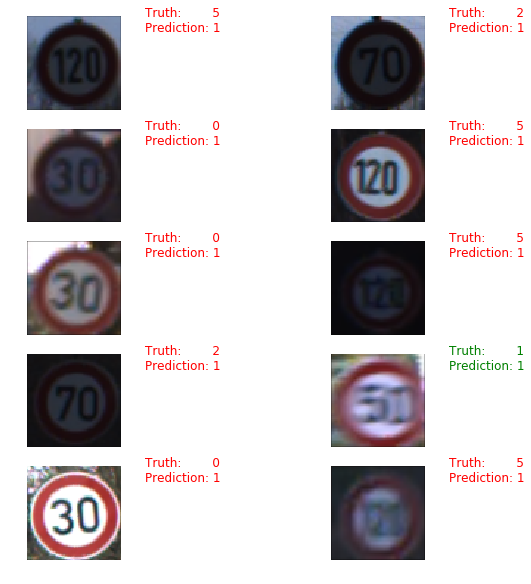

In [30]:
display_prediction(sample_images, ground_truth, predicted_categories)